## Inspiration
- https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
- https://ydf.readthedocs.io/en/latest/tutorial/getting_started/#make-predictions

!pip install ydf
!pip install tf_keras

In [1]:
import os
# Keep using Keras 2
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import ydf

import numpy as np
import pandas as pd
import tensorflow as tf
import tf_keras
import math
from itertools import product
## Do some data exploration
import seaborn as sns
import matplotlib.pyplot as plt

#
from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.29.2 is exactly one major version older than the runtime version 6.31.1 at yggdrasil_decision_forests/dataset/data_spec.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.29.2 is exactly one major version older than the runtime version 6.31.1 at yggdrasil_decision_forests/dataset/weight.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.29.2 is exactly one major version older than the runtime version 6.31.1 at yggdrasil_decision_forests/learner/abstract_learner.proto. Please update the gencode to avoid compatibili

In [2]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + ydf.__version__)

Found TensorFlow Decision Forests v0.15.0


In [3]:
## Create dataframes

In [4]:
dataset_df = pd.read_csv("../data/train.csv")
official_test_df = pd.read_csv("../data/test.csv")
submit_predict = pd.read_csv("../data/sample_submission.csv")

In [5]:
# Map Heart Disease as [0,1]
mapper = {'Absence': 0, 'Presence': 1}
label = "Heart Disease"

#classes = dataset_df[label].unique().tolist()
#print(f"Label classes: {classes}")
#dataset_df[label] = dataset_df[label].map(classes.index)
dataset_df["Heart Disease"] = dataset_df[label].map(mapper)

In [6]:
dataset_df.head(3)

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0


In [7]:
dataset_df.loc[ : , dataset_df.columns != 'id'].describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873,0.448340
std,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007,0.497324
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000,0.000000
75%,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


#### Dataset description conclusion
We see that there is an id column, totally unnecessary. <br/>
There are also some columns that have a way higher values than other columns, such as BP, Cholesterol, Max HR. 

**Conclusion**<br/>
In this project the ```id``` column should not enter any training (or test set). <br/>
In this project there should at least be one feature engineered dataset that contains normalizes columns ```BP, Cholesterol, Max HR```. <br/>
In this project there should at least be one feature engineered dataset that contains categorized columns ```Age, BP, Cholesterol, Max HR``` <br/>
Since the Thallium are categorized weirdly, lets also have one column that maps ```Thallium values: [3 6 7]``` to ```Thallium values: [0 1 2]``` 

### Data analysis

In the following section it appears that the sex 1 is over represented with 71% of the observations. <br/>
Also it shows that in sex 1 the presence of heart disease is way higher then in sex 0. <br/><br/>
According to [this study](https://pmc.ncbi.nlm.nih.gov/articles/PMC4353858/), Comparison of urinary thallium levels in non-occupationally exposed people and workers, it suggests that women have higher Thallium levels than men. So technically we can calculate the mean thallium per sex and estimate whether a 1 represents a man or woman... <br/>```dataset_df.groupby('Sex')['Thallium'].mean()``` <br/>
| Sex    | Thallium (avg) |
| -------- | ------- |
| 0  | 3.769182    |
| 1 | 4.958002     |

In [8]:
print(f"Dataset size: {len(dataset_df)}")
print(f"There are {dataset_df.isnull().sum().sum()} NaN values in the dataset.\n")
print(f"Min age: {dataset_df['Age'].min()}\tMax age: {dataset_df['Age'].max()}\n")
print(f"Heart Disease\nAbsence: {(dataset_df['Heart Disease']==0).sum()}\t\t= {round((dataset_df['Heart Disease']==0).sum()/len(dataset_df),2)}%\nPresence: {(dataset_df['Heart Disease']==1).sum()}\t= {round((dataset_df['Heart Disease']==1).sum()/len(dataset_df),2)}%\n")
print(f"Sex\n1: {(dataset_df['Sex']==1).sum()}\t\t= {round((dataset_df['Sex']==1).sum()/len(dataset_df),2)}%\n0: {(dataset_df['Sex']==0).sum()}\t\t= {round((dataset_df['Sex']==0).sum()/len(dataset_df),2)}%\n")
print(f"Sex and respective Heart Disease rates:\n{round(dataset_df.groupby('Sex')['Heart Disease'].value_counts()/len(dataset_df),2)}\n")
print(f"Thallium values: {dataset_df['Thallium'].unique()}\n")

Dataset size: 630000
There are 0 NaN values in the dataset.

Min age: 29	Max age: 77

Heart Disease
Absence: 347546		= 0.55%
Presence: 282454	= 0.45%

Sex
1: 450283		= 0.71%
0: 179717		= 0.29%

Sex and respective Heart Disease rates:
Sex  Heart Disease
0    0                0.23
     1                0.05
1    1                0.40
     0                0.32
Name: count, dtype: float64

Thallium values: [7 3 6]



### Correlations
According to the Correlation Heatmap below there are some very slight postively and negatively correlated variables, although since the they all fall between -0.5 and 0.5 I think it safe to assume there is no real correlation here and all variables are independent. <br/>
Therefore I do not think it is necessary to create new column based on combinations of independent variables.

In [9]:
matrix_pearson = dataset_df.loc[ : , dataset_df.columns != 'Heart Disease'].corr(method='pearson') 
matrix_spearman = dataset_df.loc[ : , dataset_df.columns != 'Heart Disease'].corr(method='spearman') 
matrix_kendall = dataset_df.loc[ : , dataset_df.columns != 'Heart Disease'].corr(method='kendall') 

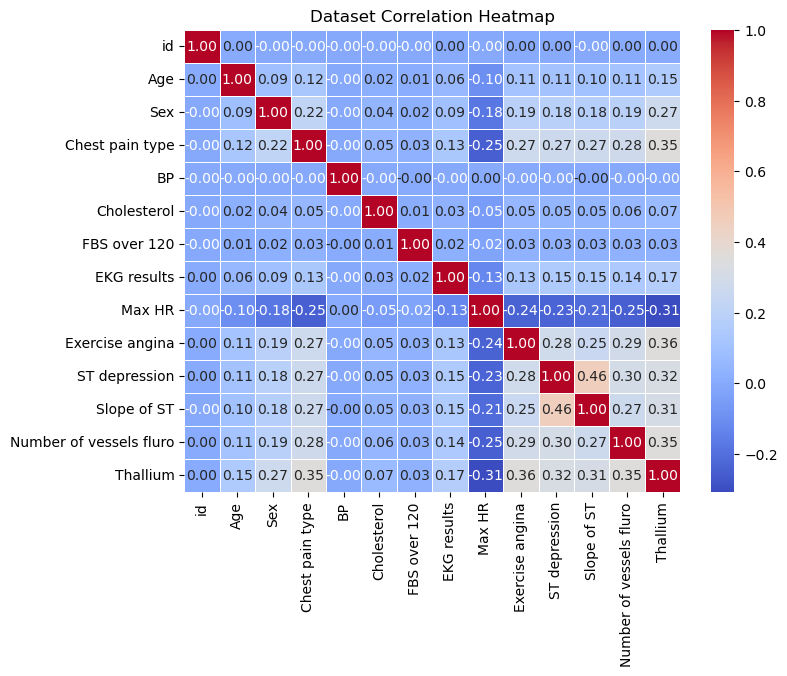

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(matrix_spearman, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Dataset Correlation Heatmap")
plt.show()

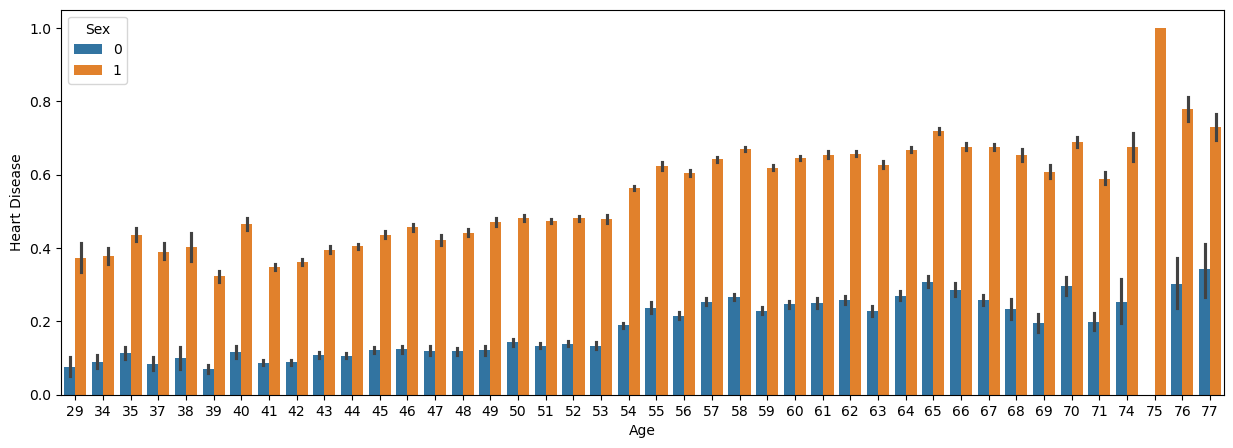

In [11]:
plt.figure(figsize=(15,5))
sns.barplot(dataset_df, x='Age', y='Heart Disease', hue='Sex')
plt.show()

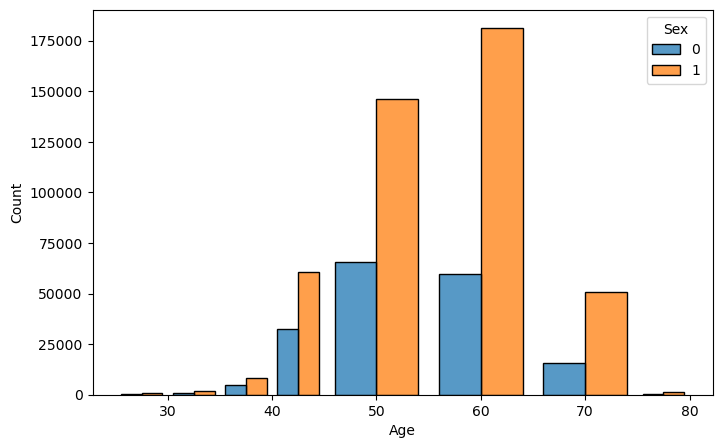

In [12]:
bins= [25,30,35,40,45,55,65,75,80]
plt.figure(figsize=(8,5))
sns.histplot(dataset_df, x='Age', bins=bins,hue='Sex', multiple="dodge", shrink=.8)
plt.show()

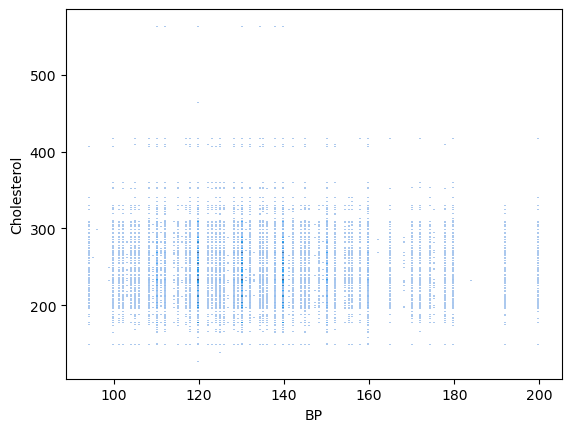

In [13]:
sns.histplot(dataset_df, x="BP", y="Cholesterol")
plt.show()

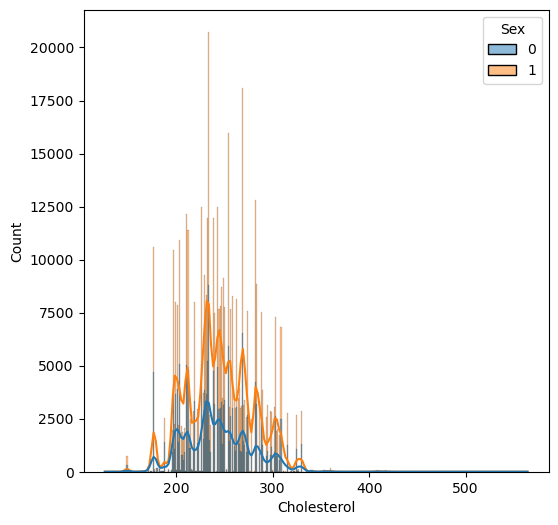

In [14]:
plt.figure(figsize=(6,6))
sns.histplot(dataset_df, x='Cholesterol', kde=True, hue='Sex')
plt.show()

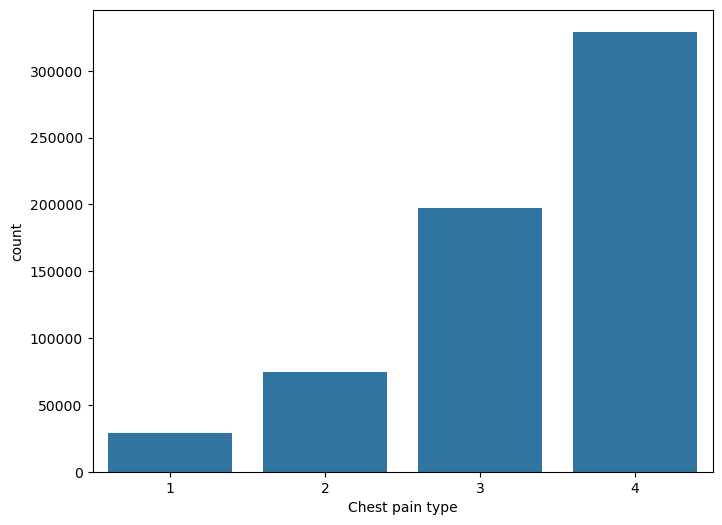

In [15]:
plt.figure(figsize=(8,6))
sns.countplot(x="Chest pain type", data=dataset_df)
plt.show()

## Feature Engineering

#### Normalize columns
```BP, Cholesterol, Max HR```

In [16]:
def normalize(df, COLUMNS_NORM):
    DATASET = df.copy()

    for COLUMN in COLUMNS_NORM:
        DATASET[COLUMN+"_norm"] = scaler.fit_transform(DATASET[[COLUMN]])       
     
    return DATASET.loc[ : , ~DATASET.columns.isin(COLUMNS_NORM)]

#### Categorize columns
```Age, BP, Cholesterol, Max HR ```
#### Map columns
```Thallium```

In [17]:
def categorize(df, COLUMNS_CAT, num_bins):
    DATASET = df.copy()
    DATASET["Thallium"+'_cat'] = DATASET["Thallium"].map(mapper_thallium)
    labels = []
    for i in range(num_bins):
        labels.append(i) 
    
    for COLUMN in COLUMNS_CAT:
        min_value = DATASET[COLUMN].min()
        max_value = DATASET[COLUMN].max()

        step_value = round((min_value + max_value)/(num_bins))

        #print(f"Step value is: {step_value}")
        breakpoints = list(np.arange(step_value, step_value*num_bins, step_value))
        #print(f"Breakpoints: {breakpoints}")
        
        DATASET[COLUMN+'_cat'] = pd.cut(DATASET[COLUMN], 
                        bins=[-np.inf] + breakpoints + [np.inf],
                        labels=labels,
                        right=False)

    return DATASET.loc[ : , ~DATASET.columns.isin(COLUMNS_CAT)]

In [18]:
# Split the dataset into a training and a testing dataset remove id.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(dataset_df.loc[ : , dataset_df.columns != 'id'])
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

441489 examples in training, 188511 examples for testing.


In [19]:
scaler = StandardScaler()
COLUMNS_NORM = ['BP', 'Cholesterol', 'Max HR']

COLUMNS_CAT = ['Age', 'BP', 'Cholesterol', 'Max HR']
mapper_thallium = {3: 0, 6: 1, 7: 2}

def update_sets(df, COLUMNS_NORM, COLUMNS_CAT, num_bins=5):
    cat_df = categorize(df, COLUMNS_CAT, num_bins)
    norm_df = normalize(df, COLUMNS_NORM)
    
    return norm_df, cat_df

norm_train, cat_train = update_sets(train_ds_pd, COLUMNS_NORM, COLUMNS_CAT)
norm_test, cat_test = update_sets(test_ds_pd, COLUMNS_NORM, COLUMNS_CAT)

In [20]:
cat_train.head()

,Sex,Chest pain type,FBS over 120,EKG results,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease,Thallium_cat,Age_cat,BP_cat,Cholesterol_cat,Max HR_cat
0,1,4,0,0,1,3.6,2,2,7,1,2,2,2,1,2
1,1,1,0,2,0,0.0,1,0,3,0,0,2,2,2,3
2,0,2,0,2,0,0.0,1,0,3,0,0,2,2,1,2
3,0,3,0,2,0,1.0,2,0,3,0,0,2,2,1,2
4,1,4,0,2,1,3.8,2,3,3,1,0,2,2,1,2


In [21]:
DICT_ML_MODELS = {
    "Test":
    {
        "model":"GradientBoostedTreesLearner",
        "parameters": None,
        "trainset": {'norm_train':norm_train},
        "testset": {'norm_test':norm_test}#, 'cat_train':cat_train, 'norm_train':norm_train}
    },
    "RandomForestLearner_default":
    {
        "model":"RandomForestLearner",
        "parameters": {
            "max_depth" :[4,6,8],
            "num_trees" :[50, 70]
        },
        "trainset": {'og_train':train_ds_pd},
        "testset": {'og_test':test_ds_pd}
    }, 
    "RandomForestLearner_norm":
    {
        "model":"RandomForestLearner",
        "parameters": {
            "max_depth" :[4,6,8],
            "num_trees" :[50, 70]
        },
        "trainset": {'norm_train':norm_train},
        "testset": {'norm_test':norm_test}
    }, 
    "GradientBoostedTreesLearner_default":
    {
        "model":"GradientBoostedTreesLearner",
        "parameters": None,
        "trainset": {'og_train':train_ds_pd},
        "testset": {'og_test':test_ds_pd}
    },
    "RandomForestLearner_cat":
    {
        "model":"RandomForestLearner",
        "parameters": {
            "max_depth" :[4,6,8],
            "num_trees" :[50, 70]
        },
        "trainset": {'cat_train':cat_train},
        "testset": {'cat_test':cat_test}
    },
    "GradientBoostedTreesLearner_norm":
    {
        "model":"GradientBoostedTreesLearner",
        "parameters": {
            "max_depth" :[4,6,8],
            "num_trees" :[50, 70]
        },
        "trainset": {'norm_train':norm_train},
        "testset": {'norm_test':norm_test}
    },
    "GradientBoostedTreesLearner_cat":
    {
        "model":"GradientBoostedTreesLearner",
        "parameters": {
            "max_depth" :[4,6,8],
            "num_trees" :[50, 70]
        },
        "trainset": {'cat_train':cat_train},
        "testset": {'cat_test':cat_test}
    }
}

In [22]:
class Model():
    def __init__(self, name, model, trainset, testset, parameters):
        self.name = name
        self.model = model
        self.parameters = parameters
        self.trainset = trainset
        self.testset = testset

        print(f"Initializing: {name}...\nmodel: {model},\ntrainset {list(trainset.keys())}\ntestset {list(testset.keys())}\nparameters: {parameters}...\n")
        
        for df in trainset.values():
            self.trainset = df
            
        for df in testset.values():
            self.testset = df

    def train(self):        
        model_class = getattr(ydf, self.model)      
        combinations = []
        
        try:
            self.trained_model
            print(f"{self.name} already trained")
        except AttributeError:
            print(f"Training model {self.name}")

            if self.parameters:
                self.keys = self.parameters.keys()
                self.values = self.parameters.values()
            
                # Generate all combinations
                for combination in product(*self.values):
                    # Create a dictionary mapping parameter names to values
                    params = dict(zip(self.keys, combination))                
    
                    print(f"Parameters: {params}")
                    self.trained_model = model_class(label=label, **params).train(self.trainset)                
    
                    is_better_ml_model = self.predict()       
                    
                    if is_better_ml_model:
                        print("Update model")
                        self.model_details = {"trained_model":self.trained_model, "parameters":params}
                        DICT_ML_MODELS[self.name].update(self.model_details)
            else:
                self.trained_model = model_class(label=label).train(self.trainset) 
                self.predict()
                self.model_details = {"trained_model":self.trained_model, "parameters":None}
                DICT_ML_MODELS[self.name].update(self.model_details)        

    def evaluate(self):
        is_better_ml_model=True
        try:
            print(f"Comparing model {self.name} with previous evaluation")
            self.evaluation.accuracy
            self.new_evalutation = self.trained_model.evaluate(self.testset)
            print(f"old: {self.evaluation.accuracy}")
            print(f"new: {self.new_evalutation.accuracy}")
            
            if self.evaluation.accuracy > self.new_evalutation.accuracy:
                print(f"Do nothing:\n old evalutation: {self.evaluation.accuracy} < new evaluation: {self.new_evalutation.accuracy}")
                is_better_ml_model=False
            else:
                print(f"Update evaluation:\n new evaluation: {self.new_evalutation.accuracy} > old evalutation: {self.evaluation.accuracy}")
                self.evaluation = self.new_evalutation
        except AttributeError:
            print(f"Evaluating model {self.name} for the first time")
            self.evaluation = self.trained_model.evaluate(self.testset)   
            DICT_ML_MODELS[self.name].update({"evaluation_accuracy":self.evaluation.accuracy})

        # Query individual evaluation metrics
        print(f"Test accuracy: {self.evaluation.accuracy}")

        return is_better_ml_model

    def predict(self):
        
        print(f"Predicting model {self.name}")
        self.predictions = self.trained_model.predict(self.testset)
        DICT_ML_MODELS[self.name].update({"predictions":self.predictions})

        is_better_ml_model = self.evaluate()

        return is_better_ml_model
        

    def submit(self):        
        self.output_file = 'submission_'+self.name+'.csv'
        print(f"Create submission file {self.output_file} for model {self.name}")
        
        update_set = str(list(DICT_ML_MODELS[self.name].get('trainset').keys())[0]).split("_")[0]
        print(f"Check feature engineering: trainset: {update_set}")
        df = official_test_df.copy()
        
        if update_set == 'norm':
            norm_test, cat_test = update_sets(official_test_df, COLUMNS_NORM, COLUMNS_CAT)
            df = norm_test
        elif update_set == 'cat':
            norm_test, cat_test = update_sets(official_test_df, COLUMNS_NORM, COLUMNS_CAT)
            df = cat_test

        

        submit_predict['Heart Disease'] = self.trained_model.predict(df)
        submit_predict['Heart Disease'] = np.round((submit_predict['Heart Disease']),4)
        submit_predict.to_csv(self.output_file, index=False)

        print(f"Saved submission file {self.output_file} for model {self.name}")

In [23]:
trainset = {'norm_train':norm_train}
testset = {'norm_test':norm_test}
parameters = {'max_depth':[4], 'num_trees':[50, 70]}
p = Model(model="RandomForestLearner", trainset=trainset, testset=testset, name="Test", parameters=parameters)

Initializing: Test...
model: RandomForestLearner,
trainset ['norm_train']
testset ['norm_test']
parameters: {'max_depth': [4], 'num_trees': [50, 70]}...



In [24]:
p.train()

Training model Test
Parameters: {'max_depth': 4, 'num_trees': 50}
Train model on 441489 examples
Model trained in 0:00:01.253829
Predicting model Test
Comparing model Test with previous evaluation
Evaluating model Test for the first time
Test accuracy: 0.8568412453384683
Update model
Parameters: {'max_depth': 4, 'num_trees': 70}
Train model on 441489 examples
Model trained in 0:00:01.604796
Predicting model Test
Comparing model Test with previous evaluation
old: 0.8568412453384683
new: 0.8520669881333185
Do nothing:
 old evalutation: 0.8568412453384683 < new evaluation: 0.8520669881333185
Test accuracy: 0.8568412453384683


In [25]:
p.predict()

Predicting model Test
Comparing model Test with previous evaluation
old: 0.8568412453384683
new: 0.8520669881333185
Do nothing:
 old evalutation: 0.8568412453384683 < new evaluation: 0.8520669881333185
Test accuracy: 0.8568412453384683


False

In [26]:
print(p.trained_model)

Model: RANDOM_FOREST
Task: CLASSIFICATION
Class: ydf.RandomForestModel
Use `model.describe()` for more details.



In [27]:
def create_models():
    for ml_model, values in DICT_ML_MODELS.items():
        if  'trained_model' in DICT_ML_MODELS[ml_model]:
            print(f"Model {ml_model} already in set...")
            print(f"Evaluation: {DICT_ML_MODELS[ml_model].get('evaluation_accuracy')}")
        else:
            model = Model(ml_model, DICT_ML_MODELS[ml_model].get('model'), DICT_ML_MODELS[ml_model].get('trainset'), DICT_ML_MODELS[ml_model].get('testset'), DICT_ML_MODELS[ml_model].get('parameters'))
            model.train()
    print('\nCreated all models')

In [28]:
create_models()

Model Test already in set...
Evaluation: 0.8568412453384683
Initializing: RandomForestLearner_default...
model: RandomForestLearner,
trainset ['og_train']
testset ['og_test']
parameters: {'max_depth': [4, 6, 8], 'num_trees': [50, 70]}...

Training model RandomForestLearner_default
Parameters: {'max_depth': 4, 'num_trees': 50}
Train model on 441489 examples
Model trained in 0:00:01.172663
Predicting model RandomForestLearner_default
Comparing model RandomForestLearner_default with previous evaluation
Evaluating model RandomForestLearner_default for the first time
Test accuracy: 0.8582629130395574
Update model
Parameters: {'max_depth': 4, 'num_trees': 70}
Train model on 441489 examples
Model trained in 0:00:01.636792
Predicting model RandomForestLearner_default
Comparing model RandomForestLearner_default with previous evaluation
old: 0.8582629130395574
new: 0.8579499339561086
Do nothing:
 old evalutation: 0.8582629130395574 < new evaluation: 0.8579499339561086
Test accuracy: 0.8582629130

In [29]:
def get_evaluations():
    models_evaluations = {}
    models_evaluations_accuracy = {}
    sorted_nested_dict = dict(sorted(DICT_ML_MODELS.items(),
                                 key=lambda x: x[1]['evaluation_accuracy'], 
                                 reverse=True))
    
    for model, value in sorted_nested_dict.items():
        #models_evaluations[model] = (value.get('evaluation_accuracy'), value.get('parameters') )
        models_evaluations[model] = (value.get('evaluation_accuracy'), value.get('parameters'), value.get('model'), value.get('trainset'), value.get('testset')  )
        models_evaluations_accuracy[model] = value.get('evaluation_accuracy')
    return models_evaluations



In [30]:
models_evaluations = get_evaluations()
for k,v in models_evaluations.items():
    print(f"{k}\t\t,{v}")

GradientBoostedTreesLearner_default		,(0.8865477346149562, None, 'GradientBoostedTreesLearner', {'og_train':         Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  \
0        58    1                4  152          239             0   
1        52    1                1  125          325             0   
2        56    0                2  160          188             0   
3        44    0                3  134          229             0   
4        58    1                4  140          234             0   
...     ...  ...              ...  ...          ...           ...   
629991   59    1                3  140          263             1   
629992   48    1                1  140          229             0   
629994   58    1                4  150          235             0   
629996   54    1                4  128          249             1   
629999   51    0                2  130          199             0   

        EKG results  Max HR  Exercise angina  ST depression  S

In [31]:
def make_submission_csv():
    res = next(iter(models_evaluations))
    print(res)
    model = DICT_ML_MODELS[res].get('model')
    parameters = DICT_ML_MODELS[res].get('parameters')
    trainset = DICT_ML_MODELS[res].get('trainset')
    testset = DICT_ML_MODELS[res].get('testset')
    #print(trainset)
    #model = list(models_evaluations.values())[1].get('model')
    print(f"Best model: {model}\nModel: \n")
    DICT_ML_MODELS["Best Model"] = {"model":model, "parameters":parameters, "trainset":trainset, "testsset":testset}
    z = Model(model=model, trainset=trainset, testset=testset, name="Best Model", parameters=parameters)
    z.train()
    z.submit()

    

In [32]:
make_submission_csv()

GradientBoostedTreesLearner_default
Best model: GradientBoostedTreesLearner
Model: 

Initializing: Best Model...
model: GradientBoostedTreesLearner,
trainset ['og_train']
testset ['og_test']
parameters: None...

Training model Best Model
Train model on 441489 examples
Model trained in 0:00:42.324169
Predicting model Best Model
Comparing model Best Model with previous evaluation
Evaluating model Best Model for the first time
Test accuracy: 0.8865477346149562
Create submission file submission_Best Model.csv for model Best Model
Check feature engineering: trainset: og
Saved submission file submission_Best Model.csv for model Best Model
